In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import gc
import os
import sys

sns.set_style('darkgrid')
sns.set_palette('bone')

#pd.options.display.float_format = '{:.5g}'.format
pd.options.display.float_format = '{:,.3f}'.format

print(os.listdir("./data"))

['.DS_Store', '.ipynb_checkpoints', 'test_V2.csv', 'train_V2.csv']


In [2]:
# 对象输入的笛卡尔积
def toTapleList(list1,list2):
    return list(itertools.product(list1,list2))

In [3]:
# Memory saving function credit to https://www.kaggle.com/gemartin/load-data-reduce-memory-usage
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.
    """
    start_mem = df.memory_usage().sum() / 1024**2
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                #if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                #    df[col] = df[col].astype(np.float16)
                #el
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        #else:
            #df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB --> {:.2f} MB (Decreased by {:.1f}%)'.format(
        start_mem, end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [4]:
%%time
gc.collect()
train = pd.read_csv('./data/train_V2.csv')
train = reduce_mem_usage(train)
test = pd.read_csv('./data/test_V2.csv')
test = reduce_mem_usage(test)
print(train.shape, test.shape)

Memory usage of dataframe is 983.90 MB --> 339.28 MB (Decreased by 65.5%)
Memory usage of dataframe is 413.18 MB --> 140.19 MB (Decreased by 66.1%)
(4446966, 29) (1934174, 28)
CPU times: user 36.2 s, sys: 9.92 s, total: 46.2 s
Wall time: 40.4 s


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4446966 entries, 0 to 4446965
Data columns (total 29 columns):
Id                 object
groupId            object
matchId            object
assists            int8
boosts             int8
damageDealt        float32
DBNOs              int8
headshotKills      int8
heals              int8
killPlace          int8
killPoints         int16
kills              int8
killStreaks        int8
longestKill        float32
matchDuration      int16
matchType          object
maxPlace           int8
numGroups          int8
rankPoints         int16
revives            int8
rideDistance       float32
roadKills          int8
swimDistance       float32
teamKills          int8
vehicleDestroys    int8
walkDistance       float32
weaponsAcquired    int16
winPoints          int16
winPlacePerc       float32
dtypes: float32(6), int16(5), int8(14), object(4)
memory usage: 339.3+ MB


In [6]:
pd.DataFrame(train.isna().sum())

,0
Id,0
groupId,0
matchId,0
assists,0
boosts,0
damageDealt,0
DBNOs,0
headshotKills,0
heals,0
killPlace,0


In [7]:
def drop_na(X):
    X.dropna(inplace=True)
drop_na(train)

In [8]:
train['Id'].nunique()

4446965

## EDA

### Id,groupId,matchId

In [9]:
for c in ['Id','groupId','matchId']:
    print(f'unique [{c}] count:', train[c].nunique())

unique [Id] count: 4446965
unique [groupId] count: 2026744
unique [matchId] count: 47964


### matchType

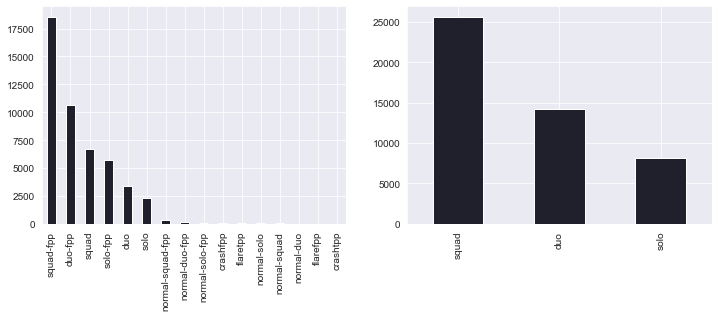

In [10]:
fig , ax = plt.subplots(1,2,figsize=(12,4))

train.groupby('matchId')['matchType'].first().value_counts().plot.bar(ax=ax[0])

'''
solo  <-- solo,solo-fpp,normal-solo,normal-solo-fpp
duo   <-- duo,duo-fpp,normal-duo,normal-duo-fpp,crashfpp,crashtpp
squad <-- squad,squad-fpp,normal-squad,normal-squad-fpp,flarefpp,flaretpp
'''
mapper = lambda x: 'solo' if ('solo' in x) else 'duo' if ('duo' in x) or ('crash' in x) else 'squad'
train['matchType'] = train['matchType'].apply(mapper)
train.groupby('matchId')['matchType'].first().value_counts().plot.bar(ax=ax[1])

### maxplace, numGroups

In [11]:
for q in ['numGroups == maxPlace','numGroups != maxPlace']:
    print(q, ':', len(train.query(q)))

numGroups == maxPlace : 1241089
numGroups != maxPlace : 3205876


groups in match

In [12]:
# describe
cols = ['numGroups','maxPlace']
desc1 = train.groupby('matchType')[cols].describe()[toTapleList(cols,['min','mean','max'])]
# groups in match
group = train.groupby(['matchType','matchId','groupId']).count().groupby(['matchType','matchId']).size().to_frame('groups in match')
desc2 = group.groupby('matchType').describe()[toTapleList(['groups in match'],['min','mean','max'])]

pd.concat([desc1, desc2], axis=1)

numGroups                maxPlace                groups in match  \
                min   mean     max      min   mean     max             min   
matchType                                                                    
duo           1.000 45.812  52.000    3.000 47.609  52.000           1.000   
solo          1.000 91.115 100.000    2.000 93.909 100.000           1.000   
squad         2.000 27.039  37.000    2.000 27.983  37.000           2.000   

                          
            mean     max  
matchType                 
duo       45.349  52.000  
solo      85.680 100.000  
squad     26.835  37.000

In [17]:
match = train.groupby(['matchType','matchId']).size().to_frame('players in match')
group = train.groupby(['matchType','matchId','groupId']).size().to_frame('players in group')
pd.concat([match.groupby('matchType').describe()[toTapleList(['players in match'],['min','mean','max'])], 
           group.groupby('matchType').describe()[toTapleList(['players in group'],['min','mean','max'])]], axis=1)

players in match                players in group             
                       min   mean     max              min  mean    max
matchType                                                              
duo                  7.000 92.986 100.000            1.000 2.050 72.000
solo                 2.000 89.043 100.000            1.000 1.039 64.000
squad                5.000 93.723 100.000            1.000 3.493 74.000

Too many group players

In [18]:
print(group['players in group'].nlargest(5))
del match,group

matchType  matchId         groupId       
squad      b30f3d87189aa6  14d6b54cdec6bc    74
duo        3e029737889ce9  b8275198faa03b    72
solo       41a634f62f86b7  128b07271aa012    64
duo        7e93ce71ac6f61  7385e5fe214021    49
squad      3c2531adf5b942  e52a2e6ca30474    36
Name: players in group, dtype: int64


In [19]:
''' 
ex) matchId=='41a634f62f86b7', groupId=='128b07271aa012'
'''
subset = train[train['matchId']=='41a634f62f86b7']
sub_grp = subset[subset['groupId']=='128b07271aa012']

print('matchId==\'41a634f62f86b7\' & groupId==\'128b07271aa012\'')
print('-'*50)
print('players:',len(subset))
print('groups:',subset['groupId'].nunique())
print('numGroups:',subset['numGroups'].unique())
print('maxPlace:',subset['maxPlace'].unique())
print('-'*50)
print('max-group players:',len(sub_grp))
print('max-group winPlacePerc:',sub_grp['winPlacePerc'].unique())
print('-'*50)
print('winPlacePerc:',subset['winPlacePerc'].sort_values().unique())

matchId=='41a634f62f86b7' & groupId=='128b07271aa012'
--------------------------------------------------
players: 97
groups: 34
numGroups: [34]
maxPlace: [97]
--------------------------------------------------
max-group players: 64
max-group winPlacePerc: [0.28119999]
--------------------------------------------------
winPlacePerc: [0.         0.0104     0.0208     0.0312     0.0417     0.0521
 0.0625     0.0729     0.0833     0.0938     0.1042     0.1146
 0.125      0.1354     0.14579999 0.15620001 0.16670001 0.1771
 0.1875     0.1979     0.20829999 0.21879999 0.22920001 0.2396
 0.25       0.2604     0.27079999 0.28119999 0.7604     0.77079999
 0.89579999 0.91670001 0.9896     1.        ]


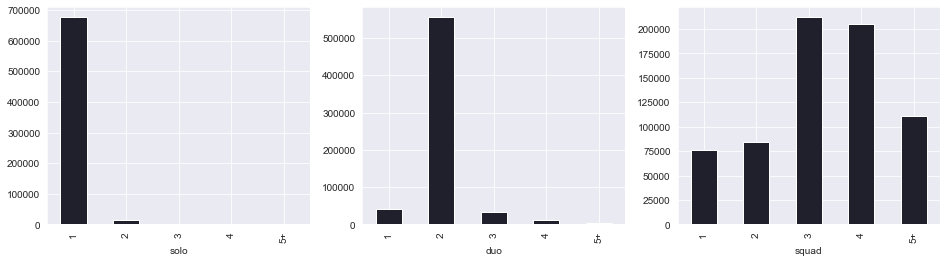

In [21]:
group = train.groupby(['matchId','groupId','matchType'])['Id'].count().to_frame('players').reset_index()
group.loc[group['players'] > 4, 'players'] = '5+'
group['players'] = group['players'].astype(str)

fig, ax = plt.subplots(1, 3, figsize=(16, 4))
for mt, ax in zip(['solo','duo','squad'], ax.ravel()):
    ax.set_xlabel(mt)
    group[group['matchType'] == mt]['players'].value_counts().sort_index().plot.bar(ax=ax)

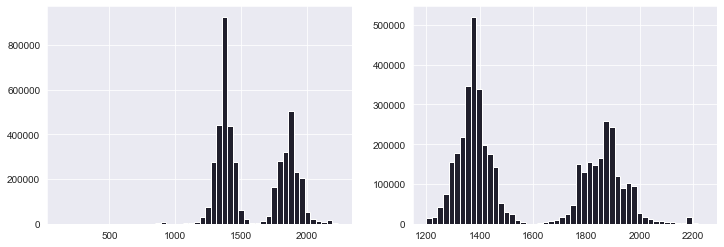

In [24]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
# there are two types of maps?
train['matchDuration'].hist(bins=50, ax=ax[0])
train.query('matchDuration >= 1200 & matchDuration <= 2300')['matchDuration'].hist(bins=50, ax=ax[1])

#### min matchDuration

In [25]:
train[train['matchDuration'] == train['matchDuration'].min()].head()

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
1206365,28f2bb56074e95,311a5a9adf1a96,e5a77433bc436f,0,0,100.000,0,1,0,1,...,0,0.000,0,0.000,0,0,0.280,2,0,1.000
2109739,2a5f4f18fe9e86,f290930a32548a,e5a77433bc436f,0,0,0.000,0,0,0,2,...,0,0.000,0,0.000,0,0,0.000,2,0,0.000


#### max matchDuration

In [26]:
train[train['matchDuration'] == train['matchDuration'].max()].head()

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
130663,8089c9ef1fa09e,3c909156e89431,f8e02cb4c82d7d,0,0,0.000,0,0,0,72,...,0,0.000,0,0.000,0,0,231.800,3,0,0.260
139317,3049d51e07bab3,4086a790e99513,f8e02cb4c82d7d,0,0,100.000,0,0,0,34,...,0,0.000,0,0.000,0,0,696.000,7,0,0.458
146220,cb3902c30f688c,65400d5cf84ead,f8e02cb4c82d7d,0,0,0.000,0,0,0,85,...,0,0.000,0,0.000,0,0,99.950,1,0,0.125
246201,80e022ce3a64ff,b668e37229bb2d,f8e02cb4c82d7d,0,1,96.250,0,1,0,35,...,0,0.000,0,0.000,0,0,"1,395.000",6,0,0.375
268239,0e50a3a859d3ab,9dcca2c1beb072,f8e02cb4c82d7d,0,0,0.000,0,0,0,41,...,0,0.000,0,0.000,0,0,121.700,3,0,0.906


#### same match is same duration

In [31]:
np.any(train.groupby('matchId')['matchDuration'].nunique() > 1)

False

### boosts, heals

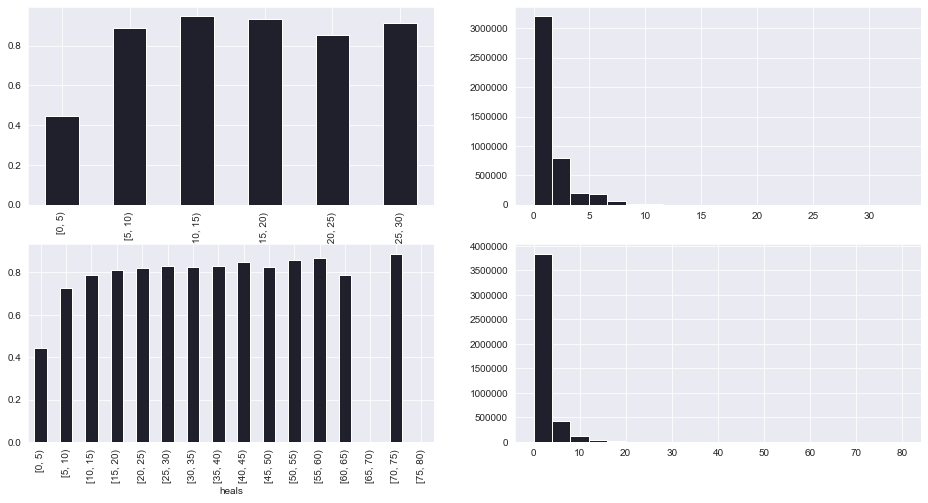

In [32]:
fig, ax = plt.subplots(2, 2, figsize=(16, 8))

cols = ['boosts','heals']
for col, ax in zip(cols, ax):
    sub = train[['winPlacePerc' , col]].copy()
    mv = (sub[col].max() // 5) + 1
    sub[col] = pd.cut(sub[col], [5 * x for x in range(0 , mv)], right=False)
    sub.groupby(col).mean()['winPlacePerc'].plot.bar(ax=ax[0])
    train[col].hist(bins=20, ax=ax[1])

### revives

In [33]:
print('solo player has revives:', 'solo' in train.query('revives > 0')['matchType'].unique())

solo player has revives: False


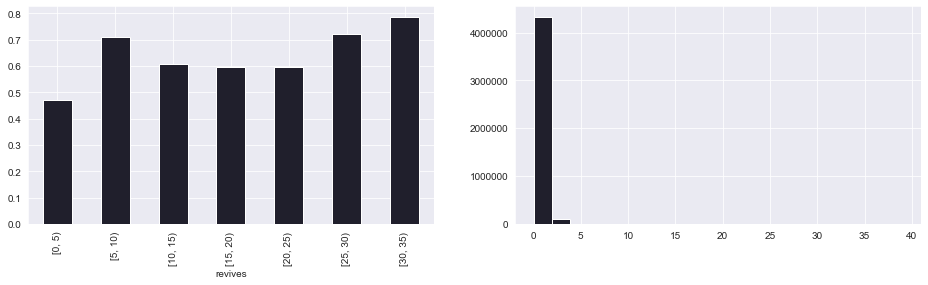

In [34]:
fig, ax = plt.subplots(1, 2, figsize=(16, 4))
col = 'revives'
sub = train.loc[~train['matchType'].str.contains('solo'),['winPlacePerc',col]].copy()
sub[col] = pd.cut(sub[col], [5*x for x in range(0,8)], right=False)
sub.groupby(col).mean()['winPlacePerc'].plot.bar(ax=ax[0]) # revives 平均 winPlace
train[col].hist(bins=20, ax=ax[1])

### killPlace

In [35]:
train.groupby(['matchType'])['killPlace'].describe()[['min','mean','max']]

,min,mean,max
matchType,,,
duo,1.000,47.471,100.000
solo,1.000,47.458,100.000
squad,1.000,47.712,101.000


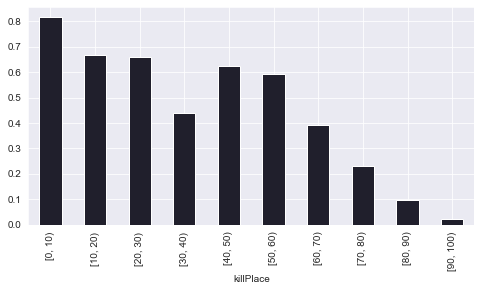

In [36]:
plt.figure(figsize=(8,4))
col = 'killPlace'
sub = train[['winPlacePerc',col]].copy()
sub[col] = pd.cut(sub[col], [10*x for x in range(0,11)], right=False)
sub.groupby(col).mean()['winPlacePerc'].plot.bar()

killPlace is a sorted ranking of kills and winPlacePerc in each match

In [37]:
''' 
important 
'''
subMatch = train[train['matchId'] == train['matchId'].min()].sort_values(['winPlacePerc','killPlace'])
cols = ['groupId','kills','winPlacePerc','killPlace']
subMatch[cols]

,groupId,kills,winPlacePerc,killPlace
3895898,3a6addfa0df938,0,0.000,94
3599150,3a6addfa0df938,0,0.000,95
4367296,236ab9e9c081b9,0,0.037,88
4131025,236ab9e9c081b9,0,0.037,89
3088817,236ab9e9c081b9,0,0.037,90
2290792,236ab9e9c081b9,0,0.037,91
1998699,236ab9e9c081b9,0,0.037,92
1425950,236ab9e9c081b9,0,0.037,93
329124,e8ff1c0fe7f6aa,0,0.074,84
729840,e8ff1c0fe7f6aa,0,0.074,85


### kills

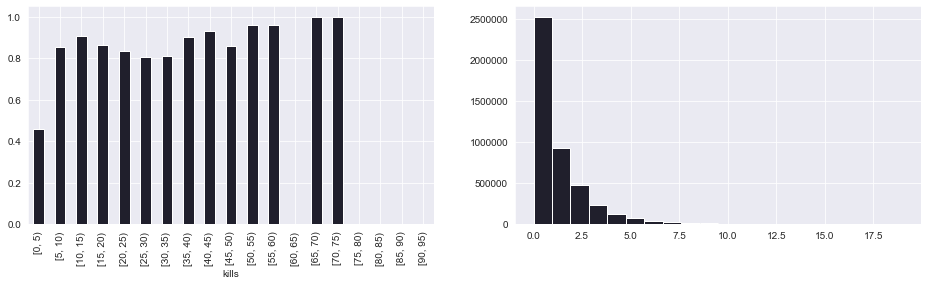

In [38]:
fig, ax = plt.subplots(1, 2, figsize=(16, 4))

col = 'kills'
sub = train[['winPlacePerc',col]].copy()
sub[col] = pd.cut(sub[col], [5*x for x in range(0,20)], right=False)
sub.groupby(col).mean()['winPlacePerc'].plot.bar(ax=ax[0])
train[train['kills'] < 20][col].hist(bins=20, ax=ax[1])

kills summary of match

In [39]:
sub = train['matchType'].str.contains('solo')
pd.concat([train.loc[sub].groupby('matchId')['kills'].sum().describe(),
         train.loc[~sub].groupby('matchId')['kills'].sum().describe()], keys=['solo','team'], axis=1).T

,count,mean,std,min,25%,50%,75%,max
solo,"8,094.000",83.421,27.592,0.000,84.000,89.000,92.000,786.000
team,"39,870.000",86.212,17.269,0.000,83.000,87.000,90.000,687.000


### killStreaks DBNOS

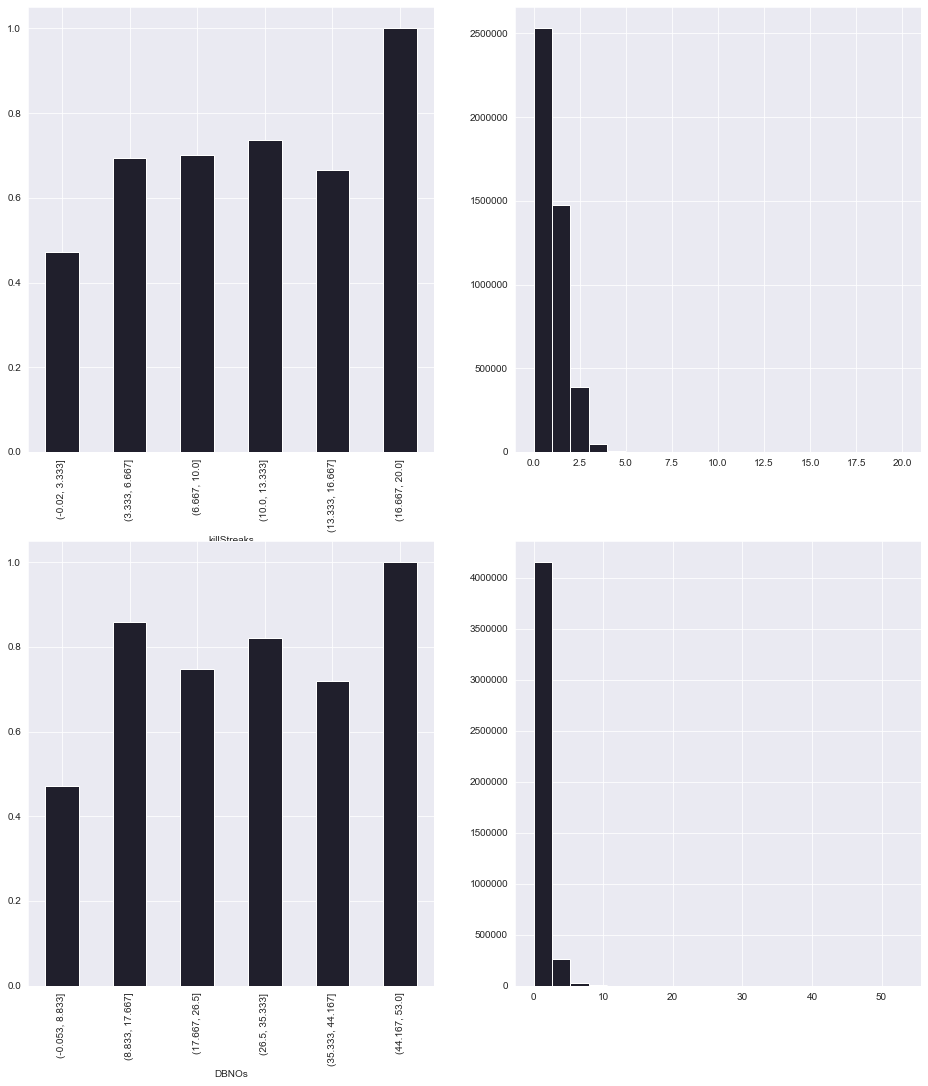

In [42]:
fig, ax = plt.subplots(2, 2, figsize=(16, 18))

cols = ['killStreaks','DBNOs']
for col, ax in zip(cols, ax):
    sub = train[['winPlacePerc',col]].copy()
    sub[col] = pd.cut(sub[col], 6)
    sub.groupby(col).mean()['winPlacePerc'].plot.bar(ax=ax[0])
    train[col].hist(bins=20, ax=ax[1])

### assists

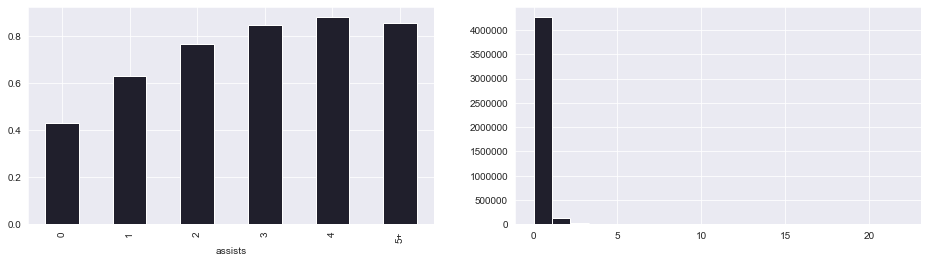

In [43]:
fig, ax = plt.subplots(1, 2, figsize=(16, 4))

col = 'assists'
sub = train[['winPlacePerc',col]].copy()
sub.loc[sub[col] >= 5, col] = '5+'  
sub[col] = sub[col].astype(str)
sub.groupby(col).mean()['winPlacePerc'].plot.bar(ax=ax[0])
train[col].hist(bins=20, ax=ax[1])

In [45]:
pd.concat([train[train['matchType'] == 'solo'].describe()['assists'],
           train[train['matchType'] != 'solo'].describe()['assists']] ,keys=['solo','team'], axis=1)

,solo,team
count,"720,712.000","3,726,253.000"
mean,0.062,0.267
std,0.298,0.624
min,0.000,0.000
25%,0.000,0.000
50%,0.000,0.000
75%,0.000,0.000
max,22.000,17.000


### longestKill

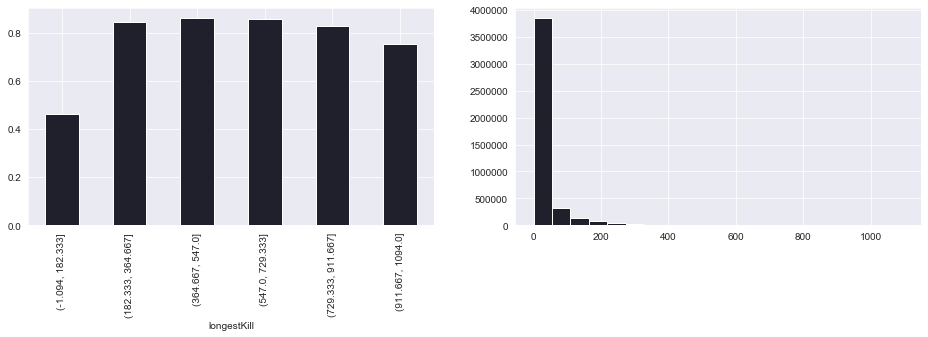

In [46]:
fig, ax = plt.subplots(1, 2, figsize=(16, 4))

col = 'longestKill'
sub = train[['winPlacePerc',col]].copy()
sub[col] = pd.cut(sub[col], 6)
sub.groupby(col).mean()['winPlacePerc'].plot.bar(ax=ax[0])
train[col].hist(bins=20, ax=ax[1])

### damage dealt

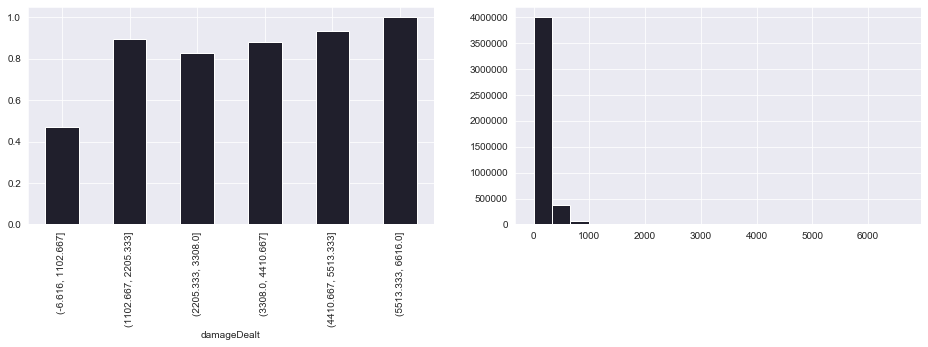

In [47]:
fig, ax = plt.subplots(1, 2, figsize=(16, 4))

col = 'damageDealt'
sub = train[['winPlacePerc',col]].copy()
sub[col] = pd.cut(sub[col], 6)
sub.groupby(col).mean()['winPlacePerc'].plot.bar(ax=ax[0])
train[col].hist(bins=20, ax=ax[1])

what this mean?

In [48]:
train.query('damageDealt == 0 & (kills > 0 | DBNOs > 0)')[
    ['damageDealt','kills','DBNOs','headshotKills','roadKills','teamKills']].head(20)

,damageDealt,kills,DBNOs,headshotKills,roadKills,teamKills
150,0.000,0,1,0,0,1
589,0.000,0,1,0,0,0
707,0.000,0,1,0,0,0
892,0.000,1,0,0,0,0
942,0.000,1,0,0,0,0
949,0.000,0,1,0,0,2
1011,0.000,0,1,0,0,0
1468,0.000,0,2,0,0,1
1625,0.000,0,1,0,0,1
2111,0.000,0,1,0,0,1


### walkDistance, rideDistance, swimDistance

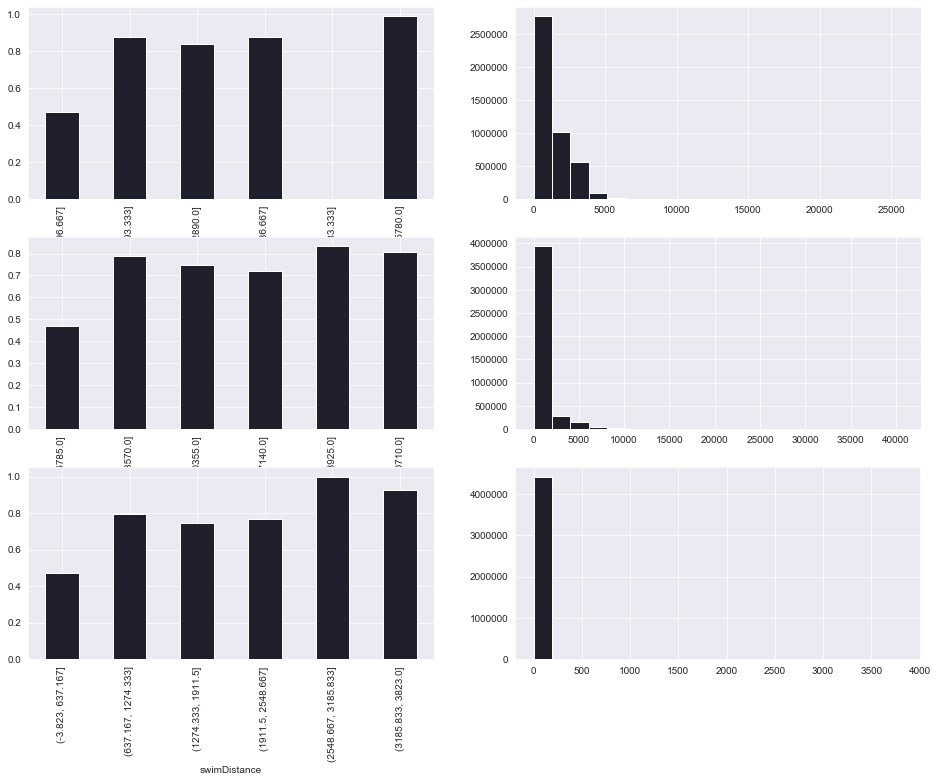

In [49]:
fig, ax = plt.subplots(3, 2, figsize=(16, 12))

cols = ['walkDistance', 'rideDistance', 'swimDistance']
for col, ax in zip(cols, ax):
    sub = train[['winPlacePerc',col]].copy()
    sub[col] = pd.cut(sub[col], 6)
    sub.groupby(col).mean()['winPlacePerc'].plot.bar(ax=ax[0])
    train[col].hist(bins=20, ax=ax[1])

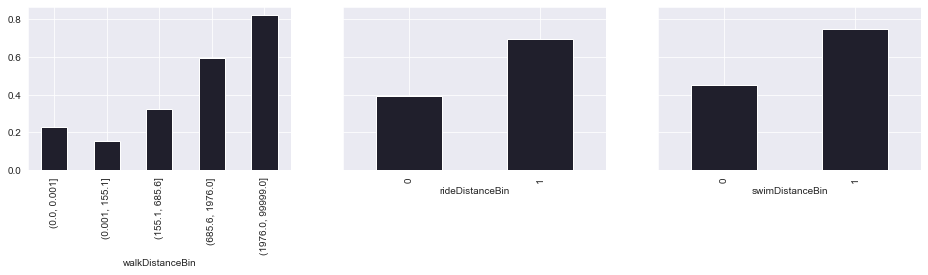

In [50]:
sub = train[['walkDistance','rideDistance','swimDistance','winPlacePerc']].copy()
walk = train['walkDistance']
sub['walkDistanceBin'] = pd.cut(walk, [0, 0.001, walk.quantile(.25), walk.quantile(.5), walk.quantile(.75), 99999])
sub['rideDistanceBin'] = (train['rideDistance'] > 0).astype(int)
sub['swimDistanceBin'] = (train['swimDistance'] > 0).astype(int)

fig, ax = plt.subplots(1, 3, figsize=(16, 3), sharey=True)
sub.groupby('walkDistanceBin').mean()['winPlacePerc'].plot.bar(ax=ax[0])
sub.groupby('rideDistanceBin').mean()['winPlacePerc'].plot.bar(ax=ax[1])
sub.groupby('swimDistanceBin').mean()['winPlacePerc'].plot.bar(ax=ax[2])
del sub, walk

zombie

In [51]:
# zombie
sub = train.query('walkDistance == 0 & kills == 0 & weaponsAcquired == 0 & \'solo\' in matchType')
print('count:', len(sub), ' winPlacePerc:', round(sub['winPlacePerc'].mean(),3))

count: 18154  winPlacePerc: 0.053


cheater

In [52]:
sq = 'kills > 3 & (headshotKills / kills) >= 0.8'
sub = train.query(sq)
print(sq, '\n count:', len(sub), ' winPlacePerc:', round(sub['winPlacePerc'].mean(),3))

kills > 3 & (headshotKills / kills) >= 0.8 
 count: 3859  winPlacePerc: 0.824


### killPoints, rankPoints, winPoints

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


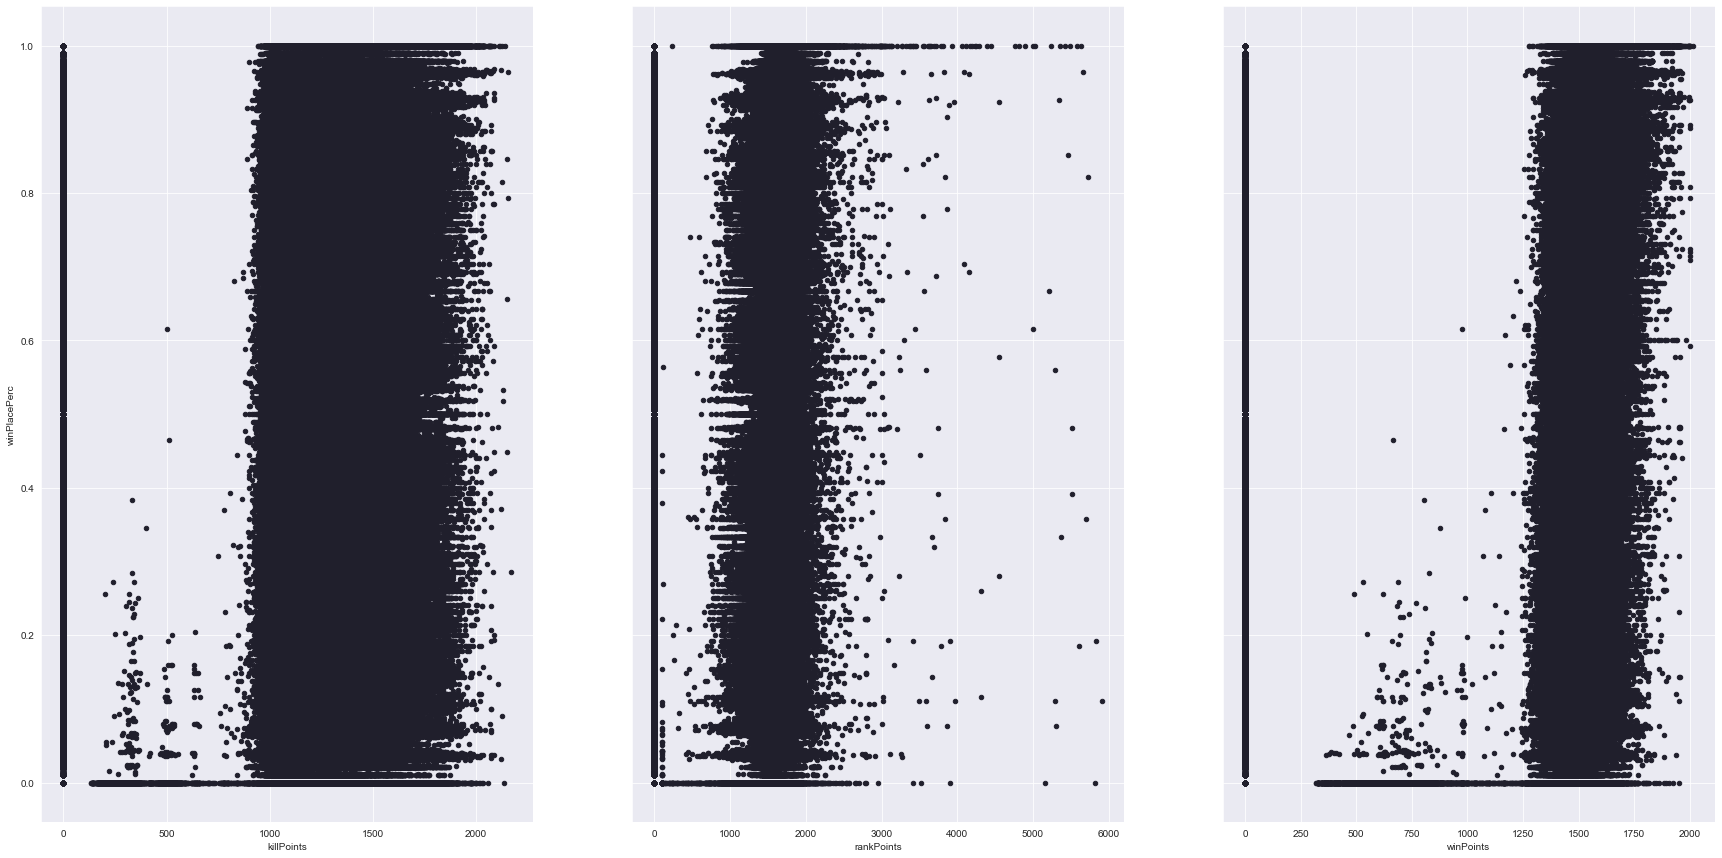

In [54]:
fig, ax = plt.subplots(1, 3, figsize=(30, 15), sharey=True)

cols = ['killPoints','rankPoints','winPoints']
for col, ax in zip(cols, ax.ravel()): 
    train.plot.scatter(x=col, y='winPlacePerc', ax=ax)

In [55]:
# rankPoint: being deprecated
# killPoints,winPoints: If there is a value other than -1 in rankPoints, then any 0 should be treated as a “None”.
sign = lambda x: 'p<=0' if x <= 0 else 'p>0'
pd.concat([
    pd.crosstab(train['rankPoints'].apply(sign), train['winPoints'].apply(sign), margins=False),
    pd.crosstab(train['rankPoints'].apply(sign), train['killPoints'].apply(sign), margins=False)
], keys=['winPoints','killPoints'], axis=1)

winPoints          killPoints         
winPoints       p<=0      p>0       p<=0      p>0
rankPoints                                       
p<=0               0  1791319          0  1791319
p>0          2655646        0    2655646        0

### winPlacePerc

In [56]:
train['winPlacePerc'].describe()

count   4,446,965.000
mean            0.473
std             0.307
min             0.000
25%             0.200
50%             0.458
75%             0.741
max             1.000
Name: winPlacePerc, dtype: float64

In [57]:
print('match count:', train['matchId'].nunique())
# not contains 1st place
maxPlacePerc = train.groupby('matchId')['winPlacePerc'].max()
print('match [not contains 1st place] : ', len(maxPlacePerc[maxPlacePerc != 1]))
del maxPlacePerc

# edge case
sub = train[(train['maxPlace'] > 1) & (train['numGroups'] == 1)]
print('match [maxPlace > 1 & numGroups == 1]:', len(sub.groupby('matchId')))
print(' - unique winPlacePerc: ', sub['winPlacePerc'].unique())

match count: 47964
match [not contains 1st place] :  74
match [maxPlace > 1 & numGroups == 1]: 68
 - unique winPlacePerc:  [0.]


In [58]:
pd.concat([train[train['winPlacePerc'] == 1].head(5),
           train[train['winPlacePerc'] == 0].head(5)],
          keys=['winPlacePerc_1', 'winPlacePerc_0'])

Id         groupId         matchId  assists  \
winPlacePerc_1 67   22252be49d4419  37fa7583da2fa2  1ce1cb998f75c7        1   
               107  7970b4ea89e81e  abf9e2780b9f48  04832cfd74ff30        1   
               118  953577684b828a  54ce33c41ef9ff  c5d412db6dbee4        2   
               123  174c758156bcf3  a935604c9bb7aa  edc87c8d445823        1   
               186  eb7a3e9f50eca5  fe3d74f737cd10  92338c2233be1a        0   
winPlacePerc_0 6    95959be0e21ca3  2c485a1ad3d0f1  a8274e903927a2        0   
               29   ac5b57ff39979c  857cc55b2b6001  e019e04dee4f19        0   
               62   eea397f23204bd  19650a810dbdbf  b99cd2f850c233        0   
               74   8b3cdbefd1f408  d25fc68b94f38c  128c05e4e54c63        0   
               103  c4260ce3746cf8  2e3ce1fb9b7812  8fb790bb47a1cc        0   

                    boosts  damageDealt  DBNOs  headshotKills  heals  \
winPlacePerc_1 67        5      378.800      2              3      6   
               107       1       58.360      0              0      2   
               118       6       76.110      0              0     12   
               123       9      626.200      4              3      2   
               186       5      778.000      0              3      2   
winPlacePerc_0 6         0        0.000      0              0      0   
               29        0        0.000      0              0      0   
               62        0      100.000      1              0      0   
               74        0        0.000      0              0      0   
               103       0        0.000      0              0      0   

                    killPlace  ...  revives  rideDistance  roadKills  \
winPlacePerc_1 67           4  ...        0       317.700          0   
               107         38  ...        0     5,134.000          0   
               118         45  ...        1         0.000          0   
               123          4  ...        0     1,045.000          0   
               186          2  ...        0         0.000          0   
winPlacePerc_0 6           96  ...        0         0.000          0   
               29          87  ...        0         0.000          0   
               62          41  ...        0         0.000          0   
               74          91  ...        0         0.000          0   
               103         94  ...        0         0.000          0   

                    swimDistance  teamKills vehicleDestroys  walkDistance  \
winPlacePerc_1 67          0.000          0               1     3,120.000   
               107         0.000          0               0     2,708.000   
               118         0.000          0               0     2,635.000   
               123         0.000          0               0     2,814.000   
               186         0.000          0               0     2,422.000   
winPlacePerc_0 6           0.000          0               0        13.500   
               29          0.000          0               0         0.000   
               62          0.000          0               0         9.907   
               74          0.000          0               0        27.060   
               103         0.000          0               0        68.900   

                    weaponsAcquired  winPoints  winPlacePerc  
winPlacePerc_1 67                 4          0         1.000  
               107                7          0         1.000  
               118                7          0         1.000  
               123                7       1566         1.000  
               186                5       1506         1.000  
winPlacePerc_0 6                  1       1497         0.000  
               29                 0          0         0.000  
               62                 1       1514         0.000  
               74                 1          0         0.000  
               103                2          0         0.000  

[10 rows x 29 columns]

### match summary

In [59]:
cols = ['kills','teamKills','DBNOs',
        'revives','assists','boosts',
        'heals','damageDealt','walkDistance',
        'rideDistance','swimDistance','weaponsAcquired']

aggs = ['count','min','mean','max']
# summary of solo-match
grp = train.loc[train['matchType'].str.contains('solo')].groupby('matchId')
grpSolo = grp[cols].sum()
# summary of team-match
grp = train.loc[~train['matchType'].str.contains('solo')].groupby('matchId')
grpTeam = grp[cols].sum()

pd.concat([grpSolo.describe().T[aggs], grpTeam.describe().T[aggs]], keys=['solo', 'team'], axis=1)

solo                                      team        \
                    count     min       mean         max      count   min   
kills           8,094.000   0.000     83.421     786.000 39,870.000 0.000   
teamKills       8,094.000   0.000      1.023      15.000 39,870.000 0.000   
DBNOs           8,094.000   0.000      0.000       0.000 39,870.000 0.000   
revives         8,094.000   0.000      0.000       0.000 39,870.000 0.000   
assists         8,094.000   0.000      5.542     219.000 39,870.000 0.000   
boosts          8,094.000   0.000     94.373     182.000 39,870.000 0.000   
heals           8,094.000   0.000     90.303     395.000 39,870.000 0.000   
damageDealt     8,094.000 100.000 10,610.864  80,991.203 39,870.000 0.000   
walkDistance    8,094.000   0.000 85,067.086 156,265.719 39,870.000 0.000   
rideDistance    8,094.000   0.000 41,250.508 207,528.625 39,870.000 0.000   
swimDistance    8,094.000   0.000    452.993   5,222.350 39,870.000 0.000   
weaponsAcquired 8,094.000   4.000    320.019   1,860.000 39,870.000 0.000   

                                         
                       mean         max  
kills                86.212     687.000  
teamKills             2.455      76.000  
DBNOs                73.377     669.000  
revives              18.366      81.000  
assists              24.954     275.000  
boosts              104.302     227.000  
heals               134.489     424.000  
damageDealt      12,425.667  68,960.344  
walkDistance    111,468.266 216,150.875  
rideDistance     59,229.430 370,542.188  
swimDistance        410.993   9,829.961  
weaponsAcquired     343.312   1,666.000

In [61]:
grpSolo.nlargest(5, 'kills')

,kills,teamKills,DBNOs,revives,assists,boosts,heals,damageDealt,walkDistance,rideDistance,swimDistance,weaponsAcquired
matchId,,,,,,,,,,,,
cfa2775c9ef944,786.000,1.000,0.000,0.000,185.000,0.000,395.000,"80,991.203","15,327.690","17,631.699",0.000,1860
fe7043ee6221c8,691.000,2.000,0.000,0.000,219.000,18.000,53.000,"67,722.703","19,284.920","8,599.500",0.000,1497
e024bf51bf1799,516.000,3.000,0.000,0.000,159.000,0.000,60.000,"52,742.699","14,045.650","7,914.800",0.000,1109
f900de1ec39fa5,415.000,1.000,0.000,0.000,151.000,0.000,42.000,"40,134.000","8,468.610","8,739.500",0.000,877
5921b55b9e96b5,387.000,0.000,0.000,0.000,110.000,0.000,56.000,"40,473.000","11,463.260","4,915.000",0.000,837


In [60]:
grpTeam.nlargest(5, 'kills')

,kills,teamKills,DBNOs,revives,assists,boosts,heals,damageDealt,walkDistance,rideDistance,swimDistance,weaponsAcquired
matchId,,,,,,,,,,,,
6680c7c3d17d48,687.000,7.000,0.000,0.000,232.000,60.000,134.000,"65,617.102","11,311.930","8,454.950",0.000,1558
8a728def0644be,656.000,1.000,669.000,35.000,258.000,0.000,277.000,"68,960.344","27,110.521","17,190.260",0.000,1558
6bf647ecee30da,638.000,12.000,0.000,0.000,157.000,1.000,236.000,"64,173.059","67,684.250","33,173.238",0.000,1666
25830709cb9033,628.000,3.000,0.000,0.000,181.000,0.000,296.000,"65,856.797","49,591.730","32,569.000",0.000,1553
17dea22cefe62a,583.000,3.000,0.000,0.000,181.000,4.000,102.000,"61,720.801","15,640.520","20,187.859",0.000,1348


### group summary

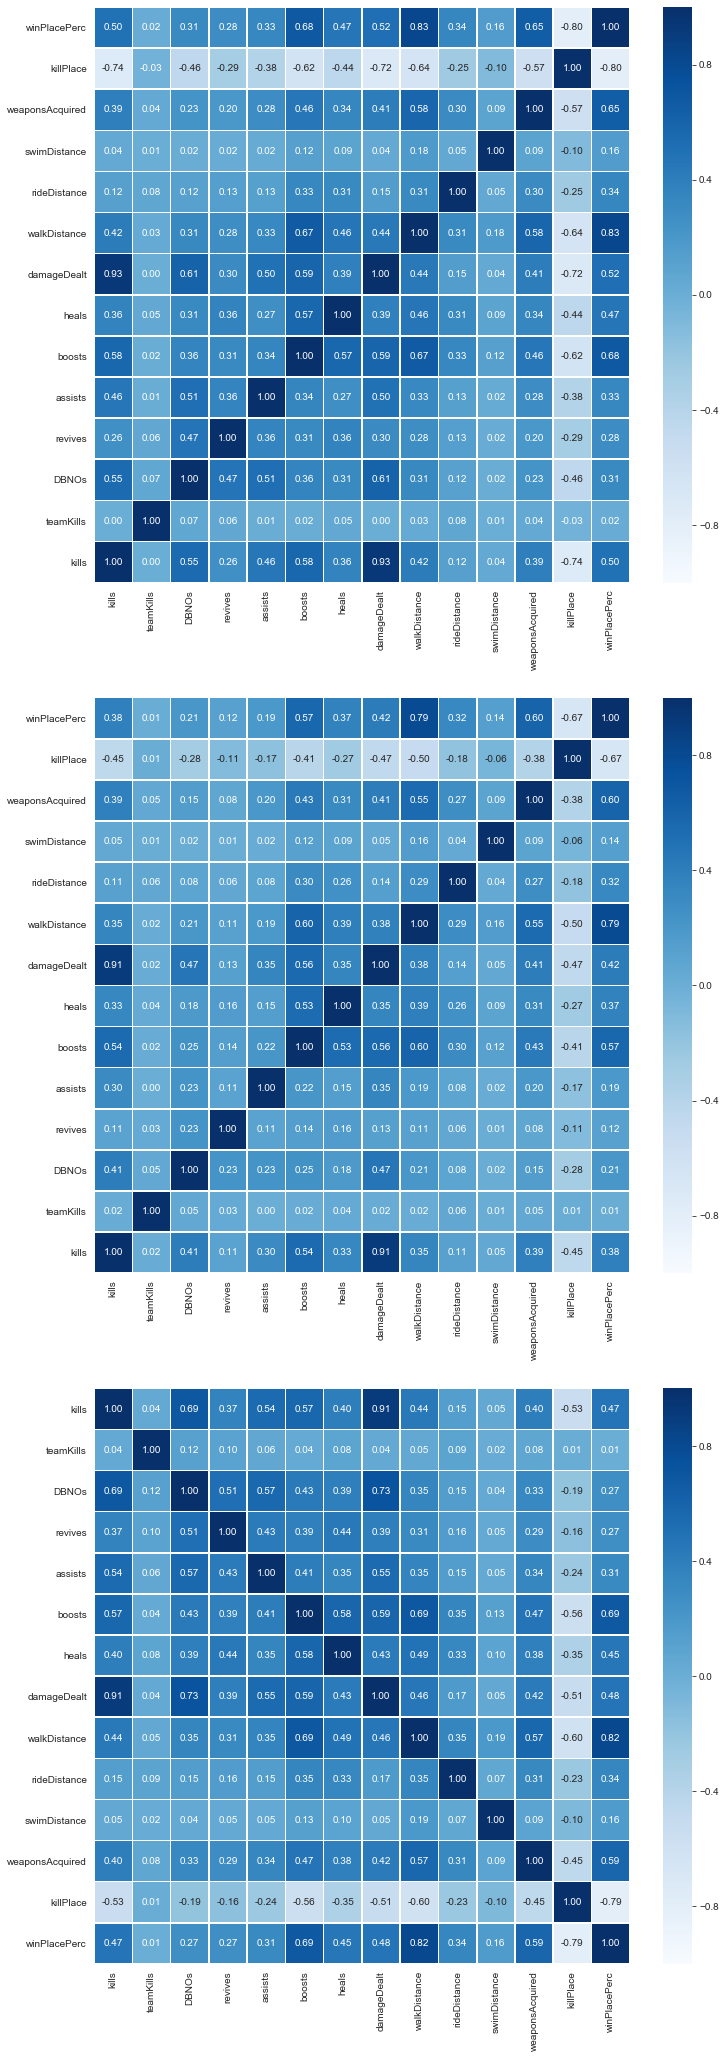

In [64]:
# 这个聚合分析没看懂
cols = ['kills','teamKills','DBNOs','revives','assists','boosts','heals','damageDealt',
    'walkDistance','rideDistance','swimDistance','weaponsAcquired']
cols.extend(['killPlace','winPlacePerc'])
group = train.groupby(['matchId','groupId'])[cols]

fig, ax = plt.subplots(3, 1, figsize=(12, 36), sharey=True)
for df, ax in zip([group.mean(), group.min(), group.max()], ax.ravel(
)):
    sns.heatmap(df.corr()
                , annot=True
                , linewidths=.6
                , fmt='.2f'
                , vmax=1
                , vmin=-1
                , center=0
                , cmap='Blues'
                , ax=ax)

del df

In [65]:
def printMatchStats(matchIds):
    for mid in matchIds:
        subMatch = train[train['matchId'] == mid]
        print('matchType:', subMatch['matchType'].values[0])

        grp1st = subMatch[subMatch['winPlacePerc'] == 1]
        grpOther = subMatch[subMatch['winPlacePerc'] != 1]
        print('players'.ljust(10), ' total:{:>3}  1st:{:>3}  other:{:>3}'.format(len(subMatch), len(grp1st), len(grpOther)))
        for c in ['kills','teamKills','roadKills','DBNOs','revives','assists']:
            print(c.ljust(10), ' total:{:>3}  1st:{:>3}  other:{:>3}'.format(subMatch[c].sum(), grp1st[c].sum(), grpOther[c].sum()))
        print('-' * 30)

In [66]:
mprintMatchStats(sampleMid)

matchType: squad
players     total: 96  1st:  4  other: 92
kills       total: 84  1st: 15  other: 69
teamKills   total:  4  1st:  0  other:  4
roadKills   total:  0  1st:  0  other:  0
DBNOs       total: 78  1st: 11  other: 67
revives     total: 14  1st:  2  other: 12
assists     total: 28  1st:  7  other: 21
------------------------------
matchType: squad
players     total: 91  1st:  4  other: 87
kills       total: 83  1st:  7  other: 76
teamKills   total:  1  1st:  0  other:  1
roadKills   total:  0  1st:  0  other:  0
DBNOs       total: 79  1st:  5  other: 74
revives     total: 17  1st:  3  other: 14
assists     total: 35  1st:  6  other: 29
------------------------------
matchType: duo
players     total: 98  1st:  2  other: 96
kills       total: 91  1st:  9  other: 82
teamKills   total:  0  1st:  0  other:  0
roadKills   total:  0  1st:  0  other:  0
DBNOs       total: 52  1st:  4  other: 48
revives     total:  7  1st:  2  other:  5
assists     total: 20  1st:  3  other: 17
-------

In [67]:
match = train.groupby(['matchId'])['Id'].count()
fullplayer = match[match == 100].reset_index()
sampleMid = fullplayer['matchId'][0:5]
printMatchStats(sampleMid)

matchType: duo
players     total:100  1st:  2  other: 98
kills       total: 95  1st:  6  other: 89
teamKills   total:  1  1st:  0  other:  1
roadKills   total:  0  1st:  0  other:  0
DBNOs       total: 59  1st:  2  other: 57
revives     total: 11  1st:  0  other: 11
assists     total: 22  1st:  0  other: 22
------------------------------
matchType: duo
players     total:100  1st:  2  other: 98
kills       total: 93  1st:  8  other: 85
teamKills   total:  3  1st:  0  other:  3
roadKills   total:  0  1st:  0  other:  0
DBNOs       total: 66  1st:  3  other: 63
revives     total: 16  1st:  1  other: 15
assists     total: 22  1st:  3  other: 19
------------------------------
matchType: squad
players     total:100  1st:  4  other: 96
kills       total: 90  1st: 10  other: 80
teamKills   total:  1  1st:  0  other:  1
roadKills   total:  0  1st:  0  other:  0
DBNOs       total: 89  1st:  8  other: 81
revives     total: 21  1st:  2  other: 19
assists     total: 35  1st:  6  other: 29
---------